In [1]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
from functions import appendImgs, loadData
from tensorflow.keras.optimizers import SGD, Adam

os.environ["CUDA_VISIBLE_DEVICES"]="3"

K.clear_session()

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
        
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(128, 128, 1))
    num_filters = 256
    
    t = Dropout(0.2)(inputs)
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = residual_block(t, downsample=False, filters=num_filters)
    
    t = Dropout(0.2)(t)
    t = residual_block(t, downsample=True, filters=num_filters)
    
    t = Dropout(0.2)(t)
    t = residual_block(t, downsample=True, filters=num_filters*2)
    
    t = Dropout(0.2)(t)
    t = Conv2D(kernel_size=1,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = Conv2D(kernel_size=3,
               strides=2,
               filters=num_filters*8,
               padding="same")(t)
    t = relu_bn(t)

    t = AveragePooling2D(8)(t)
    
    t = Dropout(0.2)(t)
    
    t = Flatten()(t)
    outputs = Dense(1, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    #optimizer = SGD(lr=0.001,momentum=0.9)
    
    model.compile(
        optimizer=SGD(lr=0.001,momentum=0.9),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

#model = create_res_net()

#model.summary()

Using TensorFlow backend.


In [2]:
def create_res_net_basic():
    
    inputs = Input(shape=(128, 128, 1))
    num_filters = 64
    
    t = Dropout(0.2)(inputs)
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    t = residual_block(t, downsample=False, filters=num_filters, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters, kernel_size=3)
    
    t = Dropout(0.2)(t)
    t = residual_block(t, downsample=True, filters=num_filters*2, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters*2, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters*2, kernel_size=3)
    
    t = Dropout(0.2)(t)
    t = residual_block(t, downsample=True, filters=num_filters*4, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters*4, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters*4, kernel_size=3)
    
    t = Dropout(0.2)(t)
    t = residual_block(t, downsample=True, filters=num_filters*8, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters*8, kernel_size=3)
    t = residual_block(t, downsample=False, filters=num_filters*8, kernel_size=3)

    t = AveragePooling2D(8)(t)   
    t = Dropout(0.2)(t)   
    t = Flatten()(t)
    outputs = Dense(1, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    #optimizer = SGD(lr=0.001,momentum=0.9)
    
    model.compile(
        optimizer=SGD(lr=0.001,momentum=0.9),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model = create_res_net_basic()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3200        dropout[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 64)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [3]:
DATA_DIR = "../fibergen/data"
TRAIN_DIR = "train"
VAL_DIR = "validation"
categories = ['thick', 'thin']

trainPath = os.path.join(DATA_DIR, TRAIN_DIR)
X_train, y_train = loadData(trainPath, categories)

valPath = os.path.join(DATA_DIR, VAL_DIR)
X_val, y_val = loadData(valPath, categories)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)

print('X_val.shape = ', X_val.shape)
print('y_val.shape = ', y_val.shape)

X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 1)

log = model.fit(
    x=X_train,
    y=y_train,
    batch_size=2,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:131: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


X_train.shape =  (4000, 128, 128)
y_train.shape =  (4000,)
X_val.shape =  (800, 128, 128)
y_val.shape =  (800,)
Train on 4000 samples, validate on 800 samples
Epoch 1/10
4000/4000 [==============================] - 50s 12ms/sample - loss: 0.4304 - accuracy: 0.7460 - val_loss: 0.0607 - val_accuracy: 0.9875
Epoch 2/10
4000/4000 [==============================] - 46s 11ms/sample - loss: 0.3766 - accuracy: 0.7530 - val_loss: 0.0752 - val_accuracy: 0.9812
Epoch 3/10
4000/4000 [==============================] - 46s 11ms/sample - loss: 0.3693 - accuracy: 0.7398 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 4/10
4000/4000 [==============================] - 46s 11ms/sample - loss: 0.3556 - accuracy: 0.7483 - val_loss: 0.0477 - val_accuracy: 0.9762
Epoch 5/10
4000/4000 [==============================] - 46s 11ms/sample - loss: 0.3597 - accuracy: 0.7442 - val_loss: 0.0331 - val_accuracy: 0.9950
Epoch 6/10
4000/4000 [==============================] - 46s 11ms/sample - loss: 0.3473 - accuracy: 0.

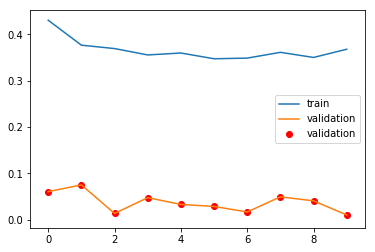

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='validation')
plt.scatter(range(0,len(log.history['val_loss'])), log.history['val_loss'], label='validation', color='red')
plt.legend()